In [67]:
#installing dependancies
!pip install -q pyspark findspark 
!pip install pandas
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -- ------------------------------------ 20.5/294.9 kB 162.5 kB/s eta 0:00:02
   -------- ------------------------------ 61.4/294.9 kB 326.1 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/294.9 kB 326.1 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 697.2 kB/s eta 0:00:01
   ------------------------------------ - 286.7/294.9 kB 980.4 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 958.5 kB/s eta 0:00:00


In [70]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession #initialise spark
from pyspark.sql.functions import col, sum as _sum

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps

In [71]:
import seaborn as sns

> **⚠️ Prerequisite Notice**  
> This notebook uses Apache Spark via PySpark.  
> Please ensure you have **Java (JDK 8 or 11)** installed and properly configured on your syste Make sure the `JAVA_HOME` environment variable is set correctly and that `java.exe` is accessible in your system PATH.H.
>  
> Without Java, the Spark session will fail to initiale.



In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Search Trends Analysis") \
    .getOrCreate()

In [4]:
#clone the GitHub repo
!git clone https://github.com/jademene/search-trends-vs-financial-markets.git

fatal: destination path 'search-trends-vs-financial-markets' already exists and is not an empty directory.


# Google Trends keywords SVI data

In [4]:
#read CSV using Spark
df_kw = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_keywords.csv', header=True, inferSchema=True) #inferSchema added to automatically type inference for columns
df_agg = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_search_trends_aggregated.csv', header=True, inferSchema=True)

## Google Trends keywords

In [6]:
#show preview keywords
df_kw.show(5)
df_kw.printSchema()

+----------+--------+-------+---------+-----------------------+-----------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+------------+-------+----------------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carfour|carrefour|carrefour autour de moi|carrefour near me|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã dom

There are several columns that only have 0 values, let's drop them and keep a list of these.

In [5]:
# Exclude 'date' from check
columns_to_check = [c for c in df_kw.columns if c != 'date']

In [6]:
kept_cols = []
dropped_cols = []

# Loop through numeric columns only
for c in columns_to_check:
    try:
        col_sum = df_kw.select(_sum(col(f"`{c}`"))).collect()[0][0]     # Use backticks in col() to safely reference columns like `E.Leclerc`
        if col_sum == 0 or col_sum is None:
            dropped_cols.append(c)
        else:
            kept_cols.append(c)
    except Exception as e:
        print(f"Skipping column '{c}' due to error: {e}")
        dropped_cols.append(c)

In [7]:
# Keep 'date' and valid keyword columns
final_cols = ['date'] + kept_cols

# Select cleaned/filtered DataFrame
df_kw_cleaned = df_kw.select(*[col(c) if c == 'date' else col(f"`{c}`") for c in final_cols])

In [11]:
# Show results
print("Dropped columns (all values were 0 or null):")
print(dropped_cols)

Dropped columns (all values were 0 or null):
['carfour', 'carrefour near me', 'IntermarchÃ©', 'carrefour bourse']


✅ Dropped columns (all values were 0 or null):

`carfour`, `carrefour near me`, `IntermarchÃ©`, `carrefour bourse`.

In [12]:
df_kw_cleaned.show(3)

+----------+--------+---------+-----------------------+---------------+-------------------+----------------------------+------------------------------+---------------+--------------+-----------------+----------------+---------------+----+---------------------+-------------------+--------------------------+------------------+-------------------+---------------------+-------------+------------------+------------------+---------------+-------------------+------------------------+------------------------+---------------+--------------------+------+----------------+---------+-------+----------------+---------------------+----+-------+----------------+--------------------+-------------------+----------------+-------------------+--------------+------------------------+
|      date|carefour|carrefour|carrefour autour de moi|carrefour drive|carrefour livraison|carrefour livraison domicile|carrefour livraison Ã domicile|drive carrefour|carrefour city|carrefour express|carrefour market|carrefour 

### EDA

In [48]:
# Convert PySpark DataFrame to Pandas
df_kw_pd = df_kw_cleaned.toPandas()

#### 1. Date Handling & Time Index Setup

In [49]:
# Ensure 'date' column is datetime and set it as the index (for time series compatibility)
df_kw_pd['date'] = pd.to_datetime(df_kw_pd['date'])
df_kw_pd.set_index('date', inplace=True)
df_kw_pd.sort_index(inplace=True)

#### 2. Statistical Summary

In [50]:
df_kw_pd.describe().T

,count,mean,std,min,25%,50%,75%,max
carefour,178.0,0.269663,0.445037,0.0,0.00,0.0,1.00,1.0
carrefour,178.0,64.342697,10.632031,47.0,56.00,62.0,70.00,100.0
carrefour autour de moi,178.0,0.067416,0.251448,0.0,0.00,0.0,0.00,1.0
carrefour drive,178.0,61.028090,12.453498,39.0,49.00,63.0,70.75,100.0
carrefour livraison,178.0,8.707865,1.466787,6.0,8.00,9.0,10.00,16.0
carrefour livraison domicile,178.0,2.606742,0.574761,2.0,2.00,3.0,3.00,5.0
carrefour livraison Ã domicile,178.0,0.011236,0.105700,0.0,0.00,0.0,0.00,1.0
drive carrefour,178.0,61.067416,12.420866,39.0,49.00,63.0,71.00,96.0
carrefour city,178.0,21.747191,5.084386,15.0,18.00,20.0,23.00,42.0
carrefour express,178.0,6.213483,1.288558,5.0,5.00,6.0,7.00,11.0


#### 3. Missing Values Analysis
Check how much missing and flat data there is with visuals.

In [62]:
missing = df_kw_pd.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("Columns with missing values:")
    print(missing)
else:
    print("No missing values found.")


No missing values found.


In [65]:
zeros = (df_kw_pd == 0).sum()
zeros = zeros[zeros > 0]

if not zeros.empty:
    print("Number of zeros in columns:")
    print(zeros)
else:
    print("No columns with zeros values found.")


Number of zeros in columns:
carefour                          130
carrefour autour de moi           166
carrefour livraison Ã domicile    176
bon d'achat carrefour              52
aloe vera carrefour               161
foire aux vins carrefour          109
franck provost carrefour          112
ongle carrefour                    51
parfumerie carrefour              134
Auchan catalogue                   40
E.Leclerc                         173
carrefour credit                   99
carrefour recrutement             172
rappel produit carrefour          158
dtype: int64


<Axes: title={'center': 'Zero SVI Counts by Keyword'}>

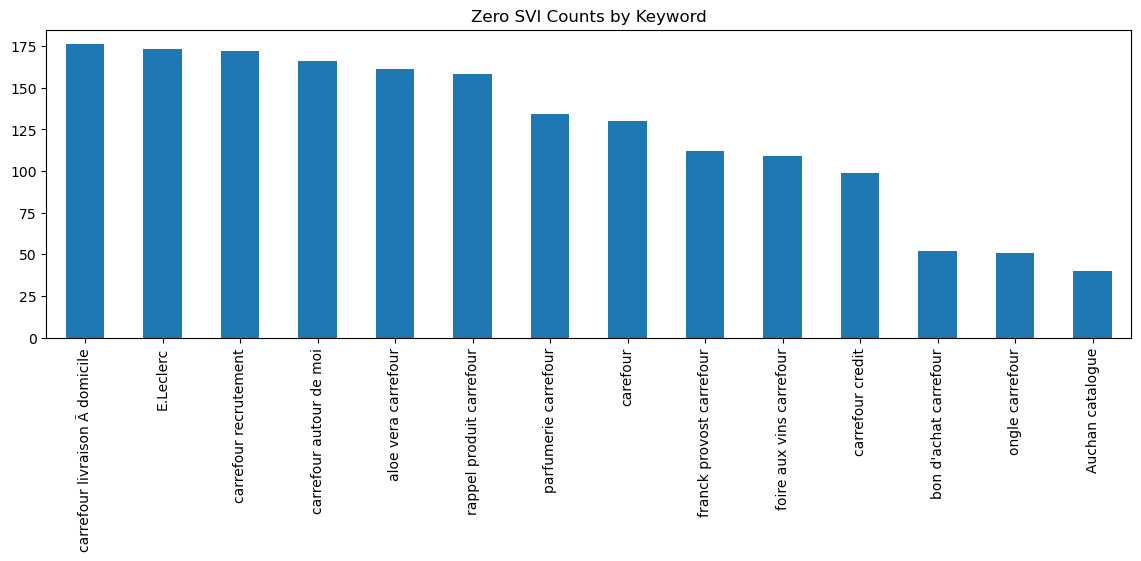

In [64]:
zeros.sort_values(ascending=False).plot(kind='bar', figsize=(14,4), title='Zero SVI Counts by Keyword')

#### 4. Time Series Trends

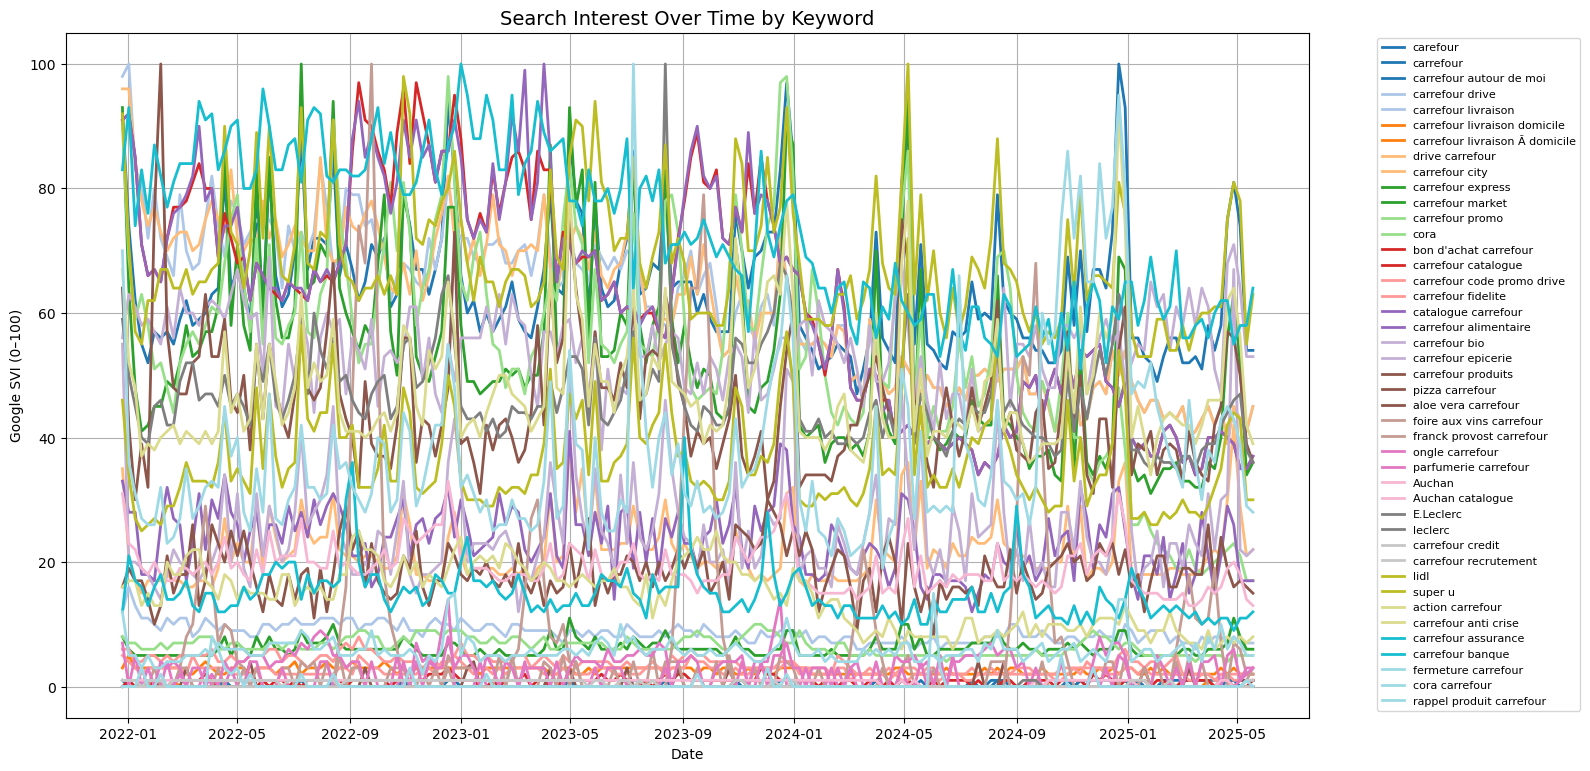

In [44]:
# Plotting all keywords 
plt.figure(figsize=(16, 8))

for idx, keyword in enumerate(df_kw_pd.columns):
    plt.plot(df_kw_pd.index, df_kw_pd[keyword], label=keyword, color=colors[idx], linewidth=2)

plt.title("Search Interest Over Time by Keyword", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

#### 5. Seasonality or Spikes

>TRY:
>
>   - Rolling mean / std (e.g. 4-week)
>   - Highlight any promotional periods or anomalies
>     
> plot grid here?

<Axes: title={'center': 'Rolling Average - Carrefour Promo'}, xlabel='date'>

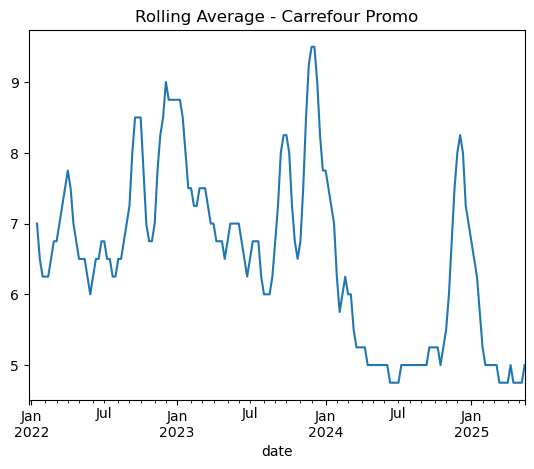

In [59]:
df_kw_pd['carrefour promo'].rolling(window=4).mean().plot(title='Rolling Average - Carrefour Promo')

#### 6. Keyword Correlation Matrix

Text(0.5, 1.0, 'Keyword Correlation Matrix')

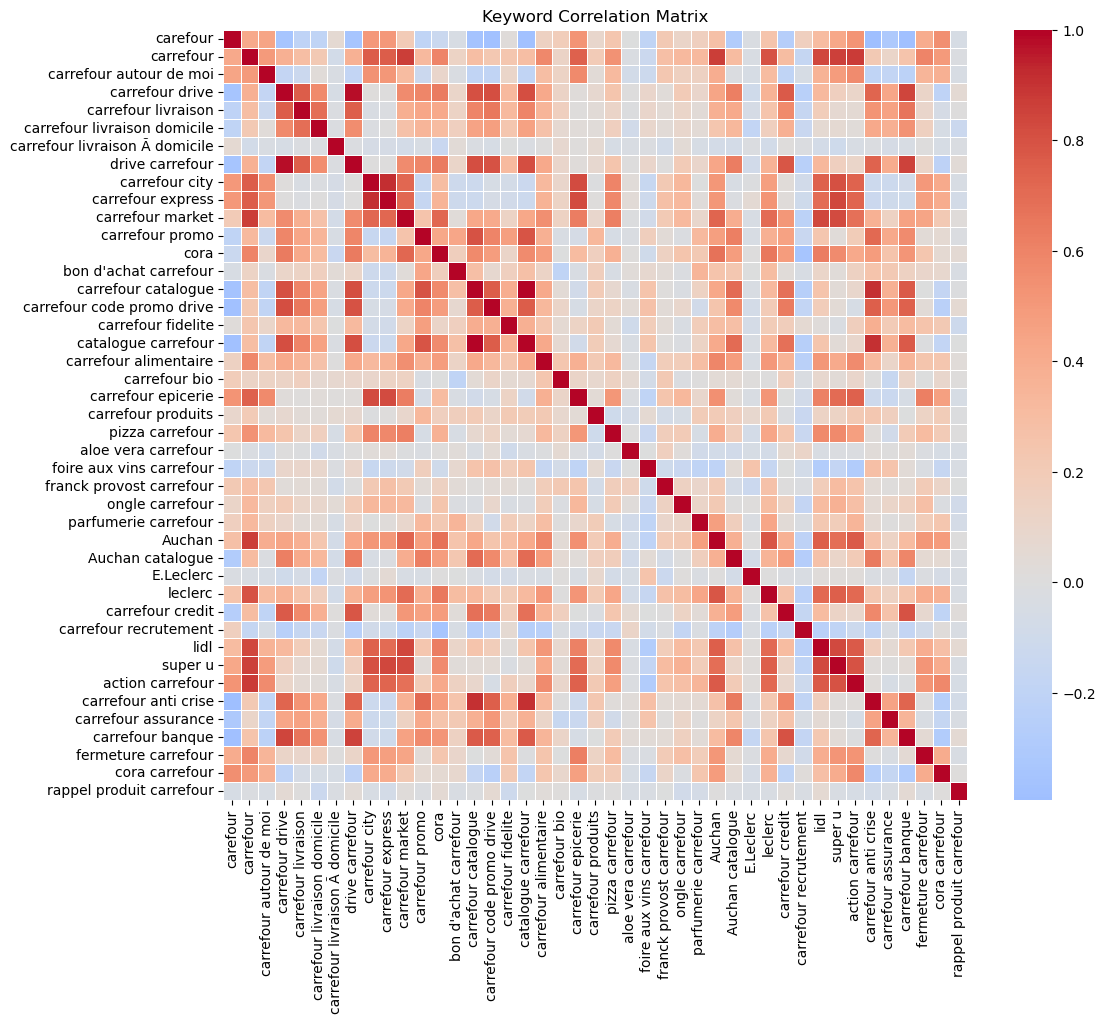

In [69]:
corr = df_kw_pd.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Keyword Correlation Matrix")

#### 7. Distribution Plot of Interest Scores

> TRY Outliers are these spikes in seasonlaity? migth want ot analyse by aggregate

<Axes: title={'center': 'SVI Distribution (Top Keywords)'}>

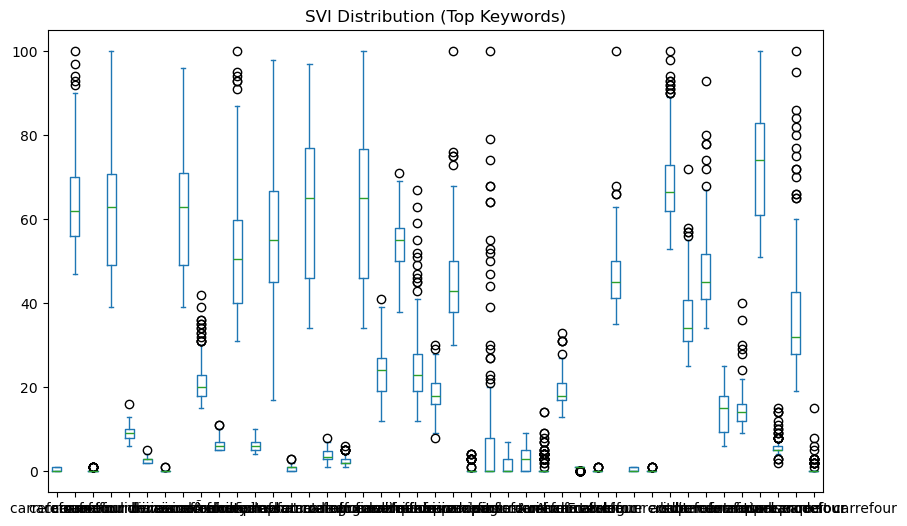

In [61]:
df_kw_pd.plot(kind='box', figsize=(10, 6), title='SVI Distribution (Top Keywords)')

#### 8. Weekly Trend Aggregation

> TRY smooth irregularities, aggregation?

### Google Trends keywords aggregated

Based on search intent, keywords can be aggregated as follows:

> ⚠️ keywords marked as ~~keywords~~ are those previously identified as "to drop"

| Aggregate | Keywords | Justification |
|---|---|---|
| Brand | carrefour, carrefour autour de moi, ~~carrefour near me~~, ~~carfour~~, carefour | Serves as an anchor term to capture general brand interest and visibility. |
| Service and logistics | carrefour drive, drive carrefour, carrefour livraison, carrefour livraison domicile, carrefour livraison Ã domicile | Reflects consumer demand for fulfillment services such as click-and-collect and home delivery, indicating operational engagement. |
| Sub-brand | carrefour market, carrefour city, carrefour express, cora | Provides more granular insight into Carrefour’s diversified retail formats and regional presence. |
| Promo and engagement | carrefour promo, carrefour code promo drive, carrefour catalogue, catalogue carrefour, carrefour fidelite, bon d'achat carrefour | Captures interest in promotions, loyalty programs, and catalogues—key drivers of footfall and conversion in price-sensitive FMCG segments. |
| FMCG products | carrefour produits, carrefour alimentaire, carrefour epicerie, carrefour bio, pizza carrefour, foire aux vins carrefour, ongle carrefour, franck provost carrefour, parfumerie carrefour, aloe vera carrefour | Reflects consumer preferences for specific product categories; interest in organic and beauty items may indicate evolving lifestyle and sustainability trends. |
| Competitors | Auchan, Auchan catalogue, E.Leclerc, leclerc, ~~IntermarchÃ©~~, lidl, super u  | Rising interest in competing retailers may signal market share shifts or influence investor sentiment regarding Carrefour. |
| Finance | ~~carrefour bourse~~, carrefour recrutement, carrefour credit, carrefour assurance, action carrefour, carrefour banque, carrefour anti crise | Indicates public engagement with Carrefour’s financial operations, job market relevance, and economic resilience. |
| News  | fermeture carrefour, rappel produit carrefour, cora carrefour | Tracks external news-driven factors, including store closures and product recalls, which may impact consumer trust or financial outlook. |


In [36]:
#show preview keywords
df_agg.show(5)
df_agg.printSchema()

+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|      date|Brand|Competitors|FMCG products|Finance|News|Promo and engagement|Service and logistics|Sub-brand|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
|26/12/2021|   93|        229|          231|    179|  82|                 201|                  209|      226|
|02/01/2022|   74|        179|          172|    184|  41|                 202|                  217|      160|
|09/01/2022|   62|        152|          161|    157|  36|                 184|                  183|      129|
|16/01/2022|   55|        140|          151|    149|  33|                 155|                  173|      124|
|23/01/2022|   52|        146|          144|    144|  31|                 146|                  160|      122|
+----------+-----+-----------+-------------+-------+----+--------------------+---------------------+---------+
o

The aggregation of the SVI data in the `carrefour_search_trends_aggregated.csv` was initially performed at the data collection stage in the following manner: 
- one column for each aggregated category (as defined in the table above);
- each row represents a time period with weekly frequency;
- each value is the sum of the SVI values for all keywords belonging to that category at that point in time.

However, this initial aggregation method is methodologically unsatisfactory. In Google Trends each keyword's SVI is scaled individually (where 0 represent the lowest relative search interest and 100 the peak relative interest within the time range selected), therefore, summing across keywords combines values on different scales. As such we risk overemphasising categories with more keywords and introduce bias if some keywords exhibit greater volatility than others.

To enhance the interpretability and methodological robustness of the analysis, alternative aggregation techniques should be considered:

| Aggregation Method   | Analysis   | 
|:---|:---|
| Simple mean | Assigns equal weight to all keywords, avoids keyword-count bias, and is easy to interpret. |
| Weighted mean | Offers higher accuracy if reliable weights (e.g., based on historical correlation or relevance) are available. |
| Z-score normalised mean | Standardises keyword volatility and expresses interest relative to each keyword’s historical mean. |
| Median | More robust to outliers and episodic spikes, especially useful with erratic or sparse search data. |
| Principal component aggregation (PCA) | Extracts the dominant shared pattern across keywords, ideal when a common driver is expected. |
| Maximum value (peak interest) | Highlights the most significant surge in attention per period, suitable for tracking event-driven spikes. |
| Frequency-based binary aggregation | Converts SVIs into binary indicators (e.g., 1 if above threshold), capturing the breadth of search interest per category. |

Using the mean as the  aggregation method is likely to be the most appropriate option as it mitigates the bias of differing keywords counts whilst also offering an intuitive measure of category-level search interest.

In [30]:
# Convert PySpark DataFrame to Pandas
df_agg_pd = df_agg.toPandas()

In [31]:
# Ensure 'date' column is datetime and set it as the index
df_agg_pd['date'] = pd.to_datetime(df_agg_pd['date'], dayfirst=True)
df_agg_pd.set_index('date', inplace=True)

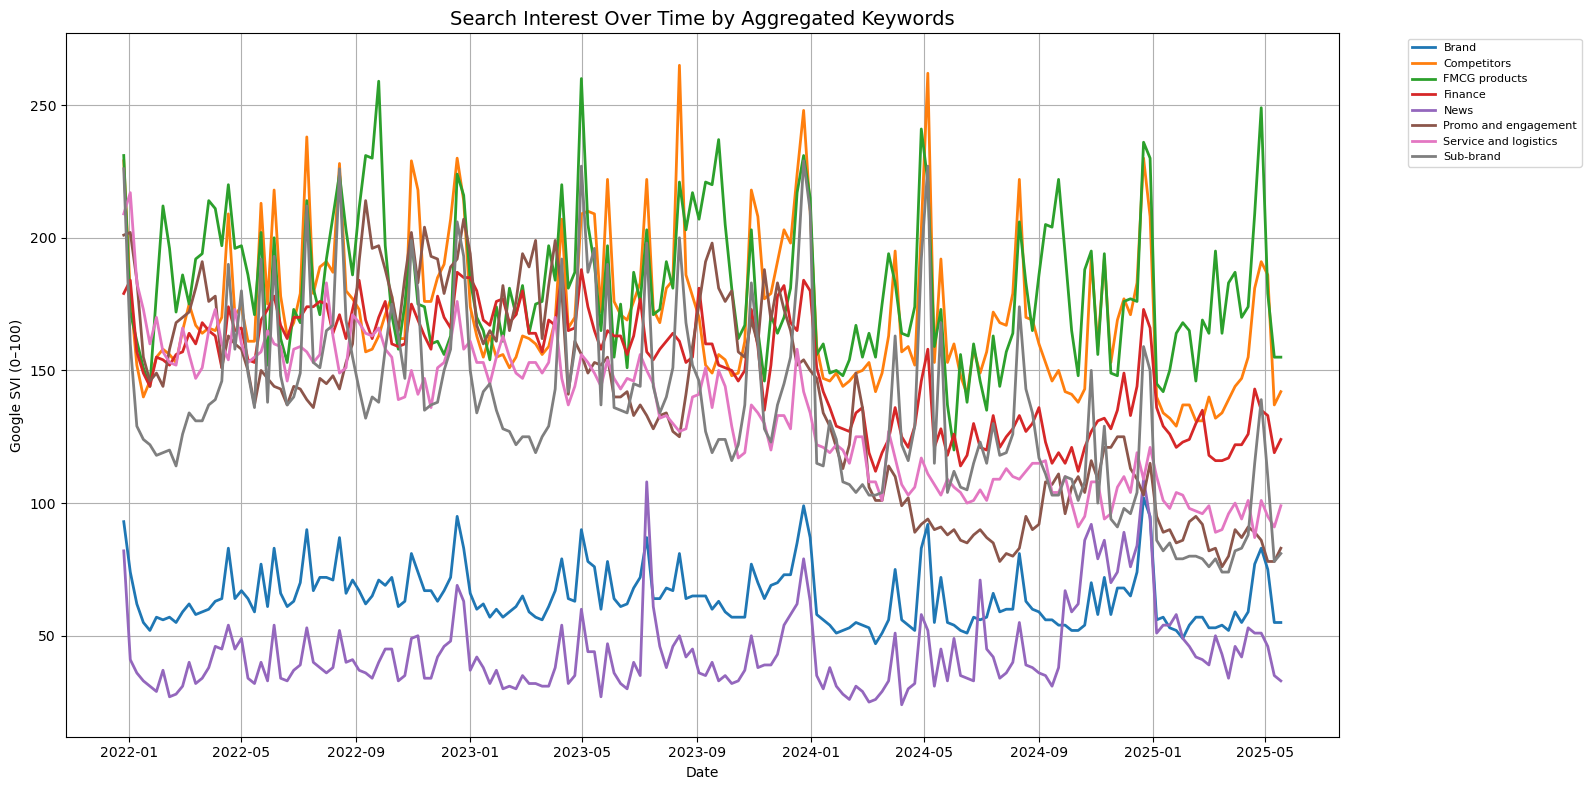

In [25]:
# Plotting all keywords 
plt.figure(figsize=(16, 8))

for keyword in df_agg_pd.columns:
    plt.plot(df_agg_pd.index, df_agg_pd[keyword], label=keyword, linewidth=2)

plt.title("Search Interest Over Time by Aggregated Keywords", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Google SVI (0–100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

# Carrefour France stock data
This data was collected in daily and weekly frequency.

In [ ]:
#read CSV using Spark
df_fin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_data.csv', header=True, inferSchema=True)
df_wfin = spark.read.csv('search-trends-vs-financial-markets/Collected Data/carrefour_stock_weekly.csv', header=True, inferSchema=True)

#### Daily stocks

In [ ]:
#show preview daily stocks
df_fin.show(5)
df_fin.printSchema()

#### Weekly stocks

In [ ]:
#show preview stocks
df_wfin.show(5)
df_wfin.printSchema()

### The time issue. 
When looking at the data collected we notice a discrepancy in date alignment. To allow the comparison of data we will need all the dataframes to share a common timeframe with matching entries.